### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.stats.mstats import winsorize
from scipy import stats
import seaborn as sns

In [22]:
# modeling

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [3]:
# Set visual style for plots
sns.set(style="whitegrid")

function for downcasting, and we will need for optimization

In [4]:
def downcaste_dtype(df):
    previous_memory_consumption = (df.memory_usage().sum()) / 1024**2 
    for col in df.columns:
        col_dtype = df[col].dtypes
        if col_dtype != 'object':
            xmin = df[col].min()
            xmax = df[col].max()
            if str(col_dtype)[0] == 'i': 
                if np.iinfo('int8').min < xmin and np.iinfo('int8').max > xmax:
                    df[col] = df[col].astype('int8')
                elif np.iinfo('int16').min < xmin and np.iinfo('int16').max > xmax:
                    df[col] = df[col].astype('int16')
                elif np.iinfo('int32').min < xmin and np.iinfo('int32').max > xmax:
                    df[col] = df[col].astype('int32')
                elif np.iinfo('int64').min < xmin and np.iinfo('int64').max > xmax:
                    df[col] = df[col].astype('int64')
                    
            elif str(col_dtype)[0] == 'f': 
                if np.finfo('float16').min < xmin and np.finfo('float16').max > xmax:
                    df[col] = df[col].astype('float16')
                elif np.finfo('float32').min < xmin and np.finfo('float32').max > xmax:
                    df[col] = df[col].astype('float32')
                elif np.finfo('float64').min < xmin and np.finfo('float64').max > xmax:
                    df[col] = df[col].astype('float64')
            else:
                pass

    after_memory_consumption = (df.memory_usage().sum()) / 1024**2
    percentage_of_decrease = ((previous_memory_consumption - after_memory_consumption) / previous_memory_consumption) * 100

    print('Memory usage before downcasting: {:.2f} MB'.format(previous_memory_consumption))
    print('After Downcasting the memory usage decreased to: {:.2f} MB'.format(after_memory_consumption))
    print('Memory usage decreased by {:.3f}%'.format(percentage_of_decrease))

    return df

### Loading Data

In [5]:
loan_applications = pd.read_csv('../DataSet/loan_applications_train.csv')

In [6]:
# optimizing
loan_applications = downcaste_dtype(loan_applications)

Memory usage before downcasting: 286.23 MB
After Downcasting the memory usage decreased to: 92.38 MB
Memory usage decreased by 67.725%


### Data Cleaning and Preprocessing

In [7]:
# Using SimpleImputer for faster mean imputation
imputer = SimpleImputer(strategy='mean')
numerical_cols = loan_applications.select_dtypes(include=[np.number]).columns
loan_applications[numerical_cols] = imputer.fit_transform(loan_applications[numerical_cols])

In [8]:
# Handling missing values for categorical columns with mode imputation
categorical_cols = loan_applications.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    loan_applications[col].fillna(loan_applications[col].mode()[0], inplace=True)

In [9]:
# Feature Engineering

# Income Ratios
loan_applications['credit_income_ratio'] = loan_applications['amt_credit'] / loan_applications['amt_income_total']
loan_applications['annuity_income_ratio'] = loan_applications['amt_annuity'] / loan_applications['amt_income_total']
loan_applications['goods_price_income_ratio'] = loan_applications['amt_goods_price'] / loan_applications['amt_income_total']

# Career Ratio
loan_applications['employment_ratio'] = loan_applications['days_employed'] / loan_applications['days_birth']
loan_applications['employment_ratio'] = loan_applications['employment_ratio'].replace([np.inf, -np.inf], np.nan)

# Family Features
loan_applications['adults_ratio'] = (loan_applications['cnt_fam_members'] - loan_applications['cnt_children']) / loan_applications['cnt_fam_members']

# Number of Overall Payments
loan_applications['payment_rate'] = loan_applications['amt_credit'] / loan_applications['amt_annuity'].replace({0: np.nan})

# External Source Features
loan_applications['ext_sources_mean'] = loan_applications[['ext_source_1', 'ext_source_2', 'ext_source_3']].mean(axis=1)
loan_applications['ext_sources_nanmean'] = loan_applications[['ext_source_1', 'ext_source_2', 'ext_source_3']].apply(lambda x: np.nanmean(x), axis=1)

# Number of Documents Submitted
doc_vars = ["flag_document_" + str(i) for i in range(2, 22)]
loan_applications['doc_count'] = loan_applications[doc_vars].sum(axis=1)

# Logarithm Transformation of Skewed Features
skewed_cols = ['amt_credit', 'amt_income_total', 'amt_goods_price', 'amt_annuity']
for col in skewed_cols:
    loan_applications['log_' + col] = np.log1p(loan_applications[col])

# Convert Days to Years
days_cols = ['days_birth', 'days_employed', 'days_registration', 'days_id_publish', 'days_last_phone_change']
for col in days_cols:
    loan_applications[col + '_years'] = np.abs(loan_applications[col]) / 365

# Age-Related Ratios
loan_applications['car_age_ratio'] = loan_applications['own_car_age'] / loan_applications['days_birth']
loan_applications['phone_change_ratio'] = loan_applications['days_last_phone_change'] / loan_applications['days_birth']


C:\Users\ABDERRAHMANE\AppData\Local\Temp\ipykernel_16592\784934114.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  loan_applications['credit_income_ratio'] = loan_applications['amt_credit'] / loan_applications['amt_income_total']
C:\Users\ABDERRAHMANE\AppData\Local\Temp\ipykernel_16592\784934114.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  loan_applications['annuity_income_ratio'] = loan_applications['amt_annuity'] / loan_applications['amt_income_total']
C:\Users\ABDERRAHMANE\AppData\Local\Temp\ipykernel_16592\7849341

In [10]:
# # Polynomial Features for numerical columns
# poly = PolynomialFeatures(degree=2, include_bias=False)
# poly_features = poly.fit_transform(loan_applications[numerical_cols])
# poly_features_df = pd.DataFrame(poly_features, columns=poly.get_feature_names(numerical_cols))
# loan_applications = loan_applications.join(poly_features_df.set_index(loan_applications.index))

In [11]:
# One-Hot Encoding for categorical variables
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_features = ohe.fit_transform(loan_applications[categorical_cols])
encoded_features_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names(categorical_cols))
loan_applications = loan_applications.drop(columns=categorical_cols).join(encoded_features_df)

c:\Users\ABDERRAHMANE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [12]:
# Winsorization to cap outliers
for col in numerical_cols:
    loan_applications[col] = winsorize(loan_applications[col], limits=[0.05, 0.05])

In [13]:
important_features = loan_applications.columns.drop('target')
# Feature Selection using RandomForest (Assuming a target variable exists)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(loan_applications[important_features], loan_applications['target'])
importances = rf.feature_importances_
important_features = [feature for feature, importance in zip(important_features, importances) if importance > np.mean(importances)]

In [14]:
# Final dataset with selected important features
loan_applications = loan_applications[important_features + ['target']]

# Display the first few rows of the processed dataset
loan_applications

# Additional checks for missing values after all transformations


sk_id_curr  amt_income_total  amt_credit  amt_annuity  \
0         117945.0          202500.0    406597.5      24700.5   
1         117945.0          270000.0   1293502.5      35698.5   
2         117945.0           67500.0    135000.0       9000.0   
3         117945.0          135000.0    312682.5      29686.5   
4         117945.0          121500.0    513000.0      21865.5   
...            ...               ...         ...          ...   
307506    438428.0          157500.0    254700.0      27558.0   
307507    438428.0           72000.0    269550.0      12001.5   
307508    438428.0          153000.0    677664.0      29979.0   
307509    438428.0          171000.0    370107.0      20205.0   
307510    438428.0          157500.0    675000.0      49117.5   

        amt_goods_price  region_population_relative  days_birth  \
0              351000.0                    0.018799     -9461.0   
1             1129500.0                    0.004959    -16765.0   
2              135000.0                    0.010033    -19046.0   
3              297000.0                    0.008018    -19005.0   
4              513000.0                    0.028656    -19932.0   
...                 ...                         ...         ...   
307506         225000.0                    0.032562     -9407.0   
307507         225000.0                    0.025162    -20775.0   
307508         585000.0                    0.005001    -14966.0   
307509         319500.0                    0.005314    -11961.0   
307510         675000.0                    0.046234    -16856.0   

        days_employed  days_registration  days_id_publish  ...  \
0              -637.0            -3648.0          -2120.0  ...   
1             -1188.0            -1186.0           -375.0  ...   
2              -225.0            -4260.0          -2531.0  ...   
3             -3039.0            -9832.0          -2437.0  ...   
4             -3038.0            -4312.0          -3458.0  ...   
...               ...                ...              ...  ...   
307506         -236.0            -8456.0          -1982.0  ...   
307507       365243.0            -4388.0          -4090.0  ...   
307508        -6743.0            -6736.0          -4944.0  ...   
307509        -4786.0            -2562.0           -931.0  ...   
307510        -1262.0            -5128.0           -410.0  ...   

        log_amt_goods_price  log_amt_annuity  days_birth_years  \
0                 12.768544        10.114619         25.920548   
1                 13.937287        10.482892         45.931507   
2                 11.813037         8.817446         52.180822   
3                 12.601491        10.298481         52.068493   
4                 13.148033         9.992711         54.608219   
...                     ...              ...               ...   
307506            12.323860        10.224084         25.553425   
307507            12.323860         9.392870         56.917808   
307508            13.279369        10.308286         41.002740   
307509            12.674516         9.913735         32.769863   
307510            13.422469        10.801991         46.180822   

        days_employed_years  days_registration_years  days_id_publish_years  \
0                  1.745205                 9.994521               5.808219   
1                  3.254795                 3.249315               0.797260   
2                  0.616438                11.671233               6.934247   
3                  8.326027                26.936986               6.676712   
4                  8.323288                11.813699               9.473973   
...                     ...                      ...                    ...   
307506             0.646575                23.167123               5.430137   
307507          1000.665753                12.021918              11.205479   
307508            21.701370                18.454795              14.109589   
307509            13.112329                 7.

In [15]:
loan_applications.isnull().sum()

sk_id_curr                      0
amt_income_total                0
amt_credit                      0
amt_annuity                     0
amt_goods_price                 0
                               ..
days_id_publish_years           0
days_last_phone_change_years    0
car_age_ratio                   0
phone_change_ratio              0
target                          0
Length: 61, dtype: int64

# Modeling

In [16]:
# Split the data into training and testing sets
X = loan_applications.drop('target', axis=1)
y = loan_applications['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Define parameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [18]:
# Set up Stratified K-Fold
stratified_kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

In [19]:
# Set up GridSearchCV with RandomForestClassifier
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=stratified_kf,
    verbose=2,
    n_jobs=-1  # Use -1 to use all processors
)

In [20]:
# Perform Grid Search
grid_search.fit(X_train, y_train)

# Best Model after Grid Search
best_rf_model = grid_search.best_estimator_

Fitting 2 folds for each of 108 candidates, totalling 216 fits


In [24]:
# Evaluating the best model

y_pred = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy_f1 = f1_score(y_test, y_pred)
print(f"Best Model Accuracy: {accuracy}")
print(f"Best Model F1_score Accuracy: {accuracy_f1}")
print("Best Model Hyperparameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred))

Best Model Accuracy: 0.9196949742288995
Best Model F1_score Accuracy: 0.012002400480096018
Best Model Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56554
         1.0       0.60      0.01      0.01      4949

    accuracy                           0.92     61503
   macro avg       0.76      0.50      0.49     61503
weighted avg       0.89      0.92      0.88     61503



### Exploratory Data Analysis (EDA)

Summary statistics

In [ ]:
summary = loan_applications.describe()

Distribution of key numerical features

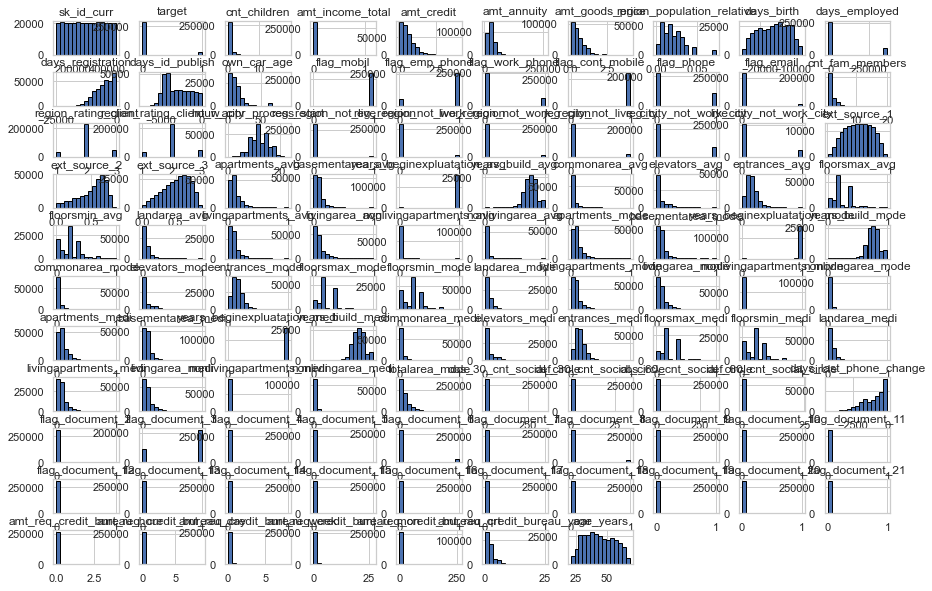

In [ ]:
loan_applications.hist(bins=15, figsize=(15, 10), edgecolor='black')
plt.subplots_adjust(hspace=0.5)

Pair Plot for selected features

Text(0.5, 0.98, 'Pairwise Plots of Key Features')

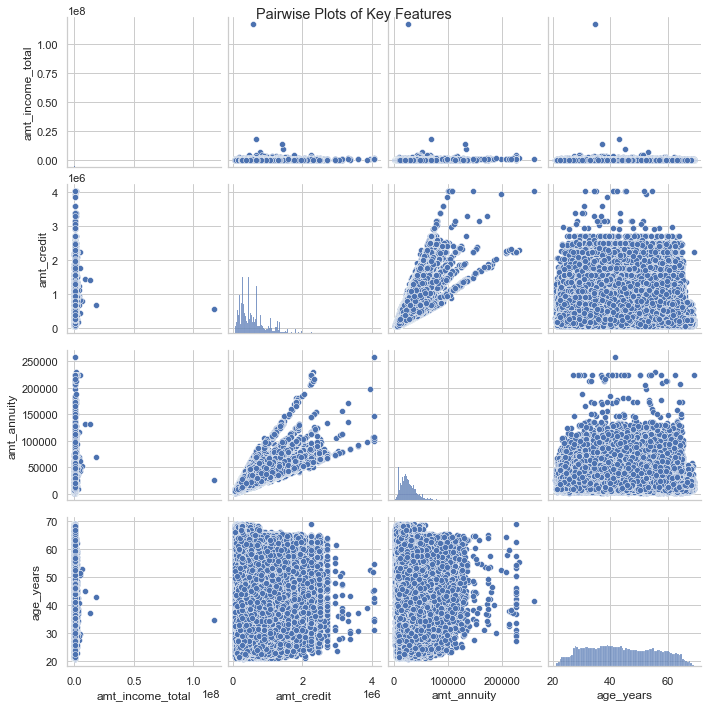

In [ ]:
selected_features = ['amt_income_total', 'amt_credit', 'amt_annuity', 'age_years']
sns.pairplot(loan_applications[selected_features])
plt.suptitle('Pairwise Plots of Key Features')

Gender distribution

Text(0.5, 1.0, 'Gender Distribution')

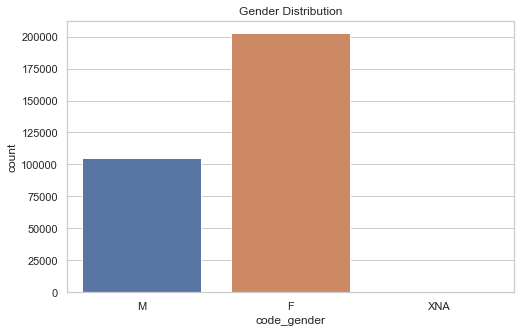

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='code_gender', data=loan_applications)
plt.title('Gender Distribution')

Income distribution (with log transformation for better visualization)

c:\Users\ABDERRAHMANE\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Frequency')

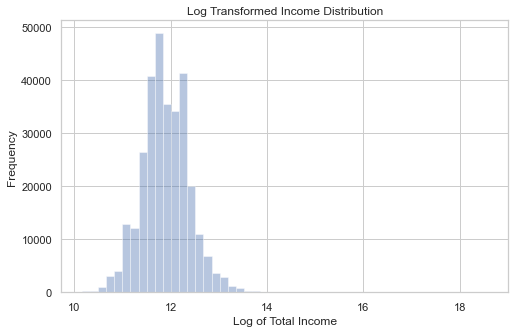

In [ ]:
plt.figure(figsize=(8, 5))
sns.distplot(np.log1p(loan_applications['amt_income_total']), kde=False)
plt.title('Log Transformed Income Distribution')
plt.xlabel('Log of Total Income')
plt.ylabel('Frequency')

Boxplot for income by gender

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='code_gender', y='amt_income_total', data=loan_applications)
plt.title('Income Distribution by Gender')

Text(0.5, 1.0, 'Income Distribution by Gender')

Correlation analysis with heatmap

Text(0.5, 1.0, 'Correlation Matrix')

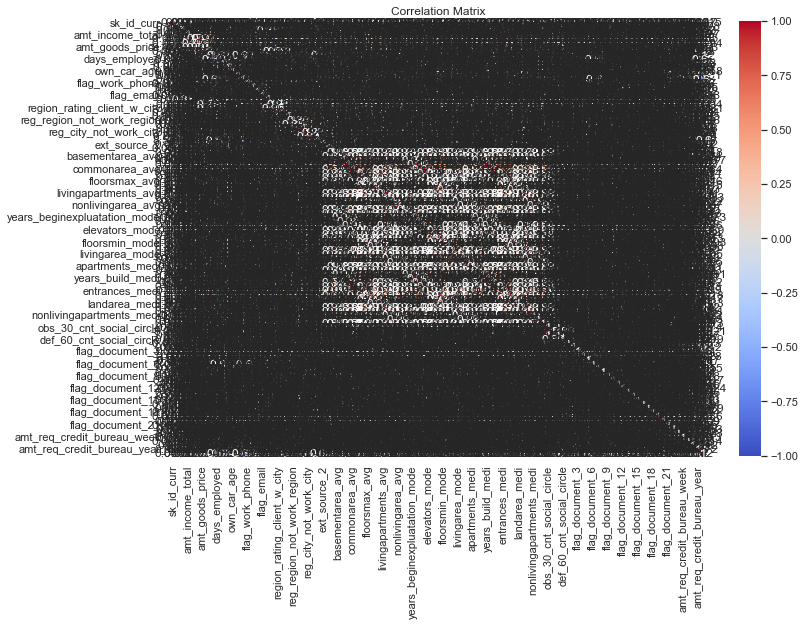

In [ ]:
correlation_matrix = loan_applications.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

Income vs Loan Amount with Hue for Contract Type

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='amt_income_total', y='amt_credit', hue='name_contract_type', data=loan_applications)
plt.title('Income vs Loan Amount by Contract Type')
plt.xlabel('Total Income')
plt.ylabel('Credit Amount')

Text(0, 0.5, 'Credit Amount')

Average income by contract type

In [ ]:
avg_income_by_contract = loan_applications.groupby('name_contract_type')['amt_income_total'].mean()

KDE Plot of Age for different Contract Types

Text(0, 0.5, 'Density')

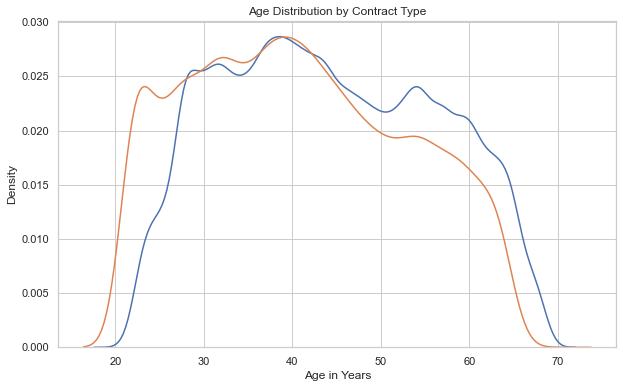

In [ ]:
plt.figure(figsize=(10, 6))
for contract_type in loan_applications['name_contract_type'].unique():
    subset = loan_applications[loan_applications['name_contract_type'] == contract_type]
    sns.kdeplot(subset['age_years'], label=contract_type)
plt.title('Age Distribution by Contract Type')
plt.xlabel('Age in Years')
plt.ylabel('Density')

Z-Score for Income, for outlier detection

In [ ]:
loan_applications['income_z_score'] = np.abs(stats.zscore(loan_applications['amt_income_total']))
outliers = loan_applications[loan_applications['income_z_score'] > 3]
outliers

sk_id_curr  target name_contract_type code_gender flag_own_car  \
1504        101769       0    Revolving loans           M            Y   
1723        102015       0         Cash loans           F            N   
3371        103938       0         Cash loans           F            N   
4603        105384       0    Revolving loans           F            Y   
5673        106637       0         Cash loans           M            Y   
...            ...     ...                ...         ...          ...   
304477      452764       0         Cash loans           F            Y   
305577      454039       0         Cash loans           M            Y   
306028      454569       0    Revolving loans           M            Y   
306179      454746       0         Cash loans           M            Y   
306285      454864       0         Cash loans           F            N   

       flag_own_realty  cnt_children  amt_income_total  amt_credit  \
1504                 Y             0         1080000.0    180000.0   
1723                 Y             0         1935000.0    269550.0   
3371                 N             1         1350000.0   2410380.0   
4603                 Y             0         1350000.0    405000.0   
5673                 Y             3          967500.0    450000.0   
...                ...           ...               ...         ...   
304477               Y             1         2025000.0    935640.0   
305577               Y             0         1215000.0   1264738.5   
306028               Y             0         1350000.0   1575000.0   
306179               Y             1          949500.0    735579.0   
306285               N             1          936000.0   1014493.5   

        amt_annuity  ...  flag_document_20 flag_document_21  \
1504         9000.0  ...                 0                0   
1723        10534.5  ...                 0                0   
3371       109053.0  ...                 0                0   
4603        20250.0  ...                 0                0   
5673        30073.5  ...                 0                0   
...             ...  ...               ...              ...   
304477      93487.5  ...                 0                0   
305577      67513.5  ...                 0                0   
306028      78750.0  ...                 0                0   
306179      35518.5  ...                 0                0   
306285      55165.5  ...                 0                0   

       amt_req_credit_bureau_hour amt_req_credit_bureau_day  \
1504                          0.0                       0.0   
1723                          0.0                       0.0   
3371                          0.0                       0.0   
4603                          0.0                       0.0   
5673                          0.0                       0.0   
...                           ...                       ...   
304477                        0.0                       0.0   
305577                        0.0                       0.0   
306028                        0.0                       0.0   
306179                        0.0                       0.0   
306285                        0.0                       0.0   

       amt_req_credit_bureau_week amt_req_credit_bureau_mon  \
1504                          0.0                       0.0   
1723                          0.0                       0.0   
3371                          0.0                       3.0   
4603                          0.0                       0.0   
5673                          0.0                       1.0   
...                           ...                       ...   
304477                        0.0                       0.0   
305577                        0.0                       0.0   
306028                        0.0                       0.0   
306179                        0.0                       0.0   
306285                        0.0                       0.0   

       